---
디시전 트리로 추천/비추천 예측
방법 1. User마다 decision tree 모델을 하나씩 갖는다.
방법 2. user각자 고려하지 않고, user_id도 feature로 사용한다

X - games features
Y - 추천 여부

In [34]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')


# Load the data
data = pd.read_csv('../datasets/merged_steam_games_.csv')

# convert date_realese columns to unixtime
data['date_release'] = pd.to_datetime(data['date_release'])
data['date_release'] = data['date_release'].apply(lambda x: int(x.timestamp()))

data['date'] = pd.to_datetime(data['date'])
data['date'] = data['date'].apply(lambda x: int(x.timestamp()))

ids = pd.DataFrame(data['app_id'])
# data = data.drop(['app_id'], axis=1)

# 전처리 안된 column 제거
data = data.drop(['categories'], axis=1)

data = data.drop(['title'], axis=1)
data = data.drop(['release_date'], axis=1)  

print(data.shape)
print(data.head())
print(data.columns)
print(data.dtypes)
print(data.describe())


(46365, 56)
   app_id  date_release  win  mac  linux  rating  positive_ratio  \
0  552520    1522022400    1    0      0       7              80   
1  552520    1522022400    1    0      0       7              80   
2  552520    1522022400    1    0      0       7              80   
3  552520    1522022400    1    0      0       7              80   
4  552520    1522022400    1    0      0       7              80   

   user_reviews  price_final  price_original  ...  RPG  Indie  \
0        129943         60.0             0.0  ...    0      0   
1        129943         60.0             0.0  ...    0      0   
2        129943         60.0             0.0  ...    0      0   
3        129943         60.0             0.0  ...    0      0   
4        129943         60.0             0.0  ...    0      0   

   Software Training  Simulation  Game Development  Massively Multiplayer  \
0                  0           0                 0                      0   
1                  0           0  

In [35]:
# 데이터셋에서 게임 데이터 분할
recommend_columns = ['app_id','helpful', 'funny', 'date', 'is_recommended', 'hours',
       'user_id']

recommend_datas = data[recommend_columns]

game_infos = data.drop(recommend_columns[1:], axis=1)

## Scailing

In [36]:
scaled_data = game_infos.copy()
scale_cols = ['date_release','positive_ratio','user_reviews','price_final','price_original', 'required_age', 'achievements', 'positive_ratings', 'negative_ratings', 
              'average_playtime', 'median_playtime', 'owners', 'price',]
# scale_cols = [col for col in scaled_data.columns if col not in no_scale_cols]
unique_values = ids['app_id'].unique()
print(unique_values)

index_positions = [ids[ids['app_id'] == value].index[0] for value in unique_values]

scaled_data = game_infos.iloc[index_positions]

# Scale the data
scaler = StandardScaler()
scaled_data[scale_cols] = scaler.fit_transform(scaled_data[scale_cols])

[552520 242760 444200 255710    220 594650 582010    550 271590 294100
 107410 292030 105600 438100 252490    570 377160  22380 239140 812140
 632360 221100 270880 251570 289070 238960 108600 548430 367520    730
 264710 646570 275850 230410 413150 359550 218620 435150    620 648800
 518790 444090 960090   4000 489830 381210 311210 374320  12210    240
    440  48700  49520 203160 227300 236390 262060 284160 291550 304930
 306130 319630 322330 346110 379720 391540 394360 578080 431960 427520
 814380 945360 477160 250900]


In [37]:
# 스케일 된 게임 데이터와 추천 데이터 다시 합치기
merged_data = pd.merge(recommend_datas, scaled_data, on='app_id')
print(merged_data.shape)

(46365, 56)


## 테스트 데이터 분리

In [38]:


Y = merged_data['is_recommended']
X = merged_data.drop(['is_recommended'], axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=156)

X_colums = merged_data.columns.drop(['is_recommended'])
df_X_train = pd.DataFrame(X_train , columns=X_colums)
df_Y_train = pd.DataFrame(Y_train, columns=['is_recommended'])
df_X_test = pd.DataFrame(X_test, columns=X_colums)
df_Y_test = pd.DataFrame(Y_test, columns=['is_recommended'])

In [62]:
def predict(target_user_id):
    # Extract training data for the target user
    train_indices = df_X_train.index[df_X_train['user_id'] == target_user_id].tolist()
    X_target_train = df_X_train.loc[train_indices]
    Y_target_train = df_Y_train.loc[train_indices]

    # Extract testing data for the target user
    test_indices = df_X_test.index[df_X_test['user_id'] == target_user_id].tolist()
    X_target_test = df_X_test.loc[test_indices]
    Y_target_test = df_Y_test.loc[test_indices]

    # Check if the extracted data is empty
    if X_target_train.empty or X_target_test.empty:
        return [], 0, 0, 0, 0, []

    # Model training
    model = DecisionTreeClassifier(max_depth=5, random_state=0)
    model.fit(X_target_train, Y_target_train)
    
    # Model prediction
    y_pred = model.predict(X_target_test)
    
    # Calculate performance metrics
    accuracy = accuracy_score(Y_target_test, y_pred)
    precision = precision_score(Y_target_test, y_pred)
    recall = recall_score(Y_target_test, y_pred)
    f1 = f1_score(Y_target_test, y_pred)
    conf_matrix = confusion_matrix(Y_target_test, y_pred)
    
    # Return the predicted values and performance metrics
    return y_pred, accuracy, precision, recall, f1, conf_matrix


In [63]:
predict()

(array([1]), 1.0, 1.0, 1.0, 1.0, array([[1]]))

In [55]:
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
cf = np.zeros((2, 2))

# Iterate through unique user IDs in the test data
for user_id in df_X_test['user_id'].unique():
    # Make predictions and calculate performance metrics for each user
    y_pred, accuracy, precision, recall, f1, conf_matrix = predict(user_id)
    
    # Convert conf_matrix to a numpy array
    conf_matrix = np.array(conf_matrix)
    
    # Append metrics to respective lists
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    
    # Ensure conf_matrix has a dimensionality of 2
    if conf_matrix.ndim == 1:
        conf_matrix = np.array([conf_matrix])
    
    # Check: If conf_matrix size is 2x2, accumulate in cf
    if conf_matrix.shape == (2, 2):
        cf += conf_matrix

# Calculate and print the mean values of the performance metrics
print('accuracy: ', np.mean(accuracy_list))
print('precision: ', np.mean(precision_list))
print('recall: ', np.mean(recall_list))
print('f1: ', np.mean(f1_list))

# Print the accumulated confusion matrix
print('confusion matrix: ', cf)


accuracy:  0.8828418506828408
precision:  0.8937452533977172
recall:  0.9014836706576768
f1:  0.8891210141388671
confusion matrix:  [[ 121.  546.]
 [ 542. 1220.]]


Text(0.5, 1.0, 'Confusion Matrix')

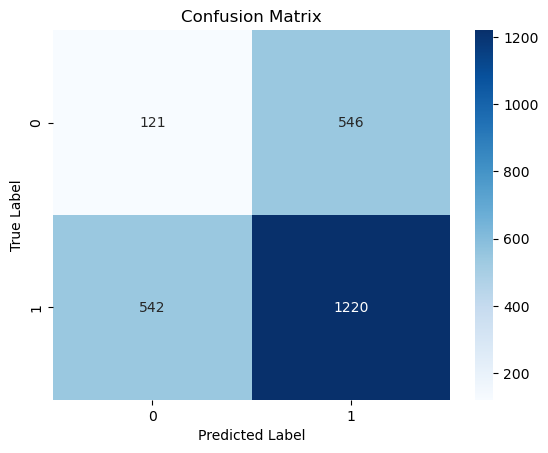

In [65]:
# Plot the confusion matrix using seaborn heatmap
from matplotlib import pyplot as plt


sns.heatmap(cf, annot=True, cmap='Blues', fmt='g')

# Set labels and title for better interpretation
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')